In [20]:
import os
import shutil
import random
from cellpose import core, utils, io, models, metrics
import torch
from glob import glob
import numpy as np
import tifffile
import cv2

torch.cuda.empty_cache()

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')


2025-04-10 16:29:59,642 [INFO] ** TORCH CUDA version installed and working. **
>>> GPU activated? YES


In [2]:
#funciones auxiliares

# Function to compute average diameter from labeled masks
def compute_average_diameter(mask_dir, max_images=20):
    diameters = []
    mask_paths = glob(os.path.join(mask_dir, "*__mask.tif"))[:max_images]

    for mask_path in mask_paths:
        mask = tifffile.imread(mask_path)
        labels = np.unique(mask)
        labels = labels[labels != 0]

        for label in labels:
            cell = (mask == label).astype(np.uint8)
            area = np.sum(cell)
            if area > 0:
                diameter = 2 * np.sqrt(area / np.pi)
                diameters.append(diameter)

    if diameters:
        avg_diameter = np.mean(diameters)
        scale_factor = 30.0 / avg_diameter  # to match Cellpose default
        return avg_diameter, scale_factor
    else:
        return None, None



# Function to resize stack images and masks using the scale factor
def resize_stack_and_mask(image_stack, mask, scale_factor):
    channels, height, width = image_stack.shape
    new_height = int(height * scale_factor)
    new_width = int(width * scale_factor)

    resized_stack = np.zeros((channels, new_height, new_width), dtype=image_stack.dtype)
    for c in range(channels):
        resized_stack[c] = cv2.resize(image_stack[c], (new_width, new_height), interpolation=cv2.INTER_LINEAR)

    resized_mask = cv2.resize(mask, (new_width, new_height), interpolation=cv2.INTER_NEAREST)

    return resized_stack, resized_mask



# Función para hacer aumentaciones simples (flip + rotación)
def augment_image_and_mask(image, mask):
    # Flip horizontal aleatorio
    if random.random() > 0.5:
        image = np.flip(image, axis=2)
        mask = np.flip(mask, axis=1)

    # Flip vertical aleatorio
    if random.random() > 0.5:
        image = np.flip(image, axis=1)
        mask = np.flip(mask, axis=0)

    # Rotación aleatoria de 0, 90, 180, 270 grados
    k = random.randint(0, 3)
    image = np.rot90(image, k, axes=(1, 2))
    mask = np.rot90(mask, k, axes=(0, 1))

    return image, mask




In [3]:


# redimensionar y aumentar imágenes y máscaras
def preprocess_dataset(
    input_folder, 
    output_folder, 
    max_images_for_diameter=20, 
    augmentations_per_image=2
):
    os.makedirs(output_folder, exist_ok=True)

    # Paso 1: calcular diámetro medio y factor de escala
    avg_diameter, scale_factor = compute_average_diameter(input_folder, max_images=max_images_for_diameter)
    print(f"Diámetro medio estimado: {avg_diameter:.2f} px")
    print(f"Factor de escala aplicado: {scale_factor:.3f}")

    # Paso 2: procesar cada par imagen-máscara
    for file in os.listdir(input_folder):
        if file.endswith('_image_stack.tif'):
            base_name = file.replace('_image_stack.tif', '')
            image_path = os.path.join(input_folder, file)
            mask_path = os.path.join(input_folder, f'{base_name}__mask.tif')

            if not os.path.exists(mask_path):
                print(f"Máscara no encontrada para {file}")
                continue

            image_stack = tifffile.imread(image_path)
            mask = tifffile.imread(mask_path)

            # Redimensionado base
            resized_stack, resized_mask = resize_stack_and_mask(image_stack, mask, scale_factor)

            # Guardar original redimensionado
            tifffile.imwrite(os.path.join(output_folder, f"{base_name}_image_stack.tif"), resized_stack)
            tifffile.imwrite(os.path.join(output_folder, f"{base_name}__mask.tif"), resized_mask)

            # Aumentaciones
            for i in range(augmentations_per_image):
                aug_stack, aug_mask = augment_image_and_mask(resized_stack.copy(), resized_mask.copy())
                tifffile.imwrite(os.path.join(output_folder, f"{base_name}_aug{i}_image_stack.tif"), aug_stack)
                tifffile.imwrite(os.path.join(output_folder, f"{base_name}_aug{i}__mask.tif"), aug_mask)

    print("Preprocesamiento completo. Imágenes redimensionadas y aumentadas guardadas.")




In [ ]:
# SOLO UNA VEZ : DATA AUGMENTATION Y REDIMENSIONADO
'''
input_folder = '/home/kryten/Desktop/Imatges_AIna/database_seg_sergi'
output_folder = '/home/kryten/Desktop/Imatges_AIna/database_seg_sergi_rs_aug'
preprocess_dataset(
    input_folder,      # carpeta donde están todas tus imágenes y máscaras
    output_folder,    # carpeta de destino para los archivos procesados
    max_images_for_diameter=20,                   # cuántas máscaras usar para estimar el diámetro
    augmentations_per_image=2                     # cuántas copias aumentadas hacer por imagen
)'''

In [21]:
output_dirs = {
    "train":"/home/kryten/Desktop/Imatges_AIna/database_seg_sergi/train",
    "test":"/home/kryten/Desktop/Imatges_AIna/database_seg_sergi/test"
}

In [22]:
#NO CORRER SI YA ESTÁN LAS CARPETAS HECHAS
source_dir = '/home/kryten/Desktop/Imatges_AIna/database_seg_sergi'
for dir_path in output_dirs.values():
    os.makedirs(dir_path, exist_ok=True)

image_files = [f for f in os.listdir(source_dir) if f.endswith("_image_stack.tif")]
pairs = [(img, img.replace("_image_stack.tif", "__mask.tif")) for img in image_files]
random.shuffle(pairs)

total = len(pairs)
train_size=int(0.8*total)
test_size=int(0.2*total)

train_pairs = pairs[:train_size]
test_pairs=pairs[train_size:]

def move_files(pairs, dest_dir):
    for img, mask in pairs:
        shutil.copy(os.path.join(source_dir, img), os.path.join(dest_dir, img))
        shutil.copy(os.path.join(source_dir, mask), os.path.join(dest_dir, mask))


move_files(train_pairs, output_dirs["train"])

move_files(test_pairs, output_dirs["test"])

print("dataset dividido correctamente")

dataset dividido correctamente


In [23]:
#@markdown ###Path to images and masks:

train_dir = output_dirs["train"] #@param {type:"string"}
test_dir = output_dirs["test"] #@param {type:"string"}
#Define where the patch file will be saved
base = source_dir

# model name and path
#@markdown ###Name of the pretrained model to start from and new model name:
from cellpose import models
initial_model = "cyto2" #@param ["cyto", "cyto3","nuclei","tissuenet_cp3", "livecell_cp3", "yeast_PhC_cp3", "yeast_BF_cp3", "bact_phase_cp3", "bact_fluor_cp3", "deepbacs_cp3", "scratch"]
model_name = "CP_sergi_cyto2_200" #@param {type:"string"}

# other parameters for training.
#@markdown ###Training Parameters:
#@markdown Number of epochs:
n_epochs = 100#@param {type:"number"}

Channel_to_use_for_training = "Red" #@param ["Grayscale", "Blue", "Green", "Red"]

# @markdown ###If you have a secondary channel that can be used for training, for instance nuclei, choose it here:

Second_training_channel= "Green" #@param ["None", "Blue", "Green", "Red"]


#@markdown ###Advanced Parameters

Use_Default_Advanced_Parameters = True #@param {type:"boolean"}
#@markdown ###If not, please input:
learning_rate = 0.001 #@param {type:"number"}
weight_decay = 0.0001 #@param {type:"number"}

if (Use_Default_Advanced_Parameters): 
  print("Default advanced parameters enabled")
  learning_rate = 0.001 
  weight_decay = 0.0001
  
#here we check that no model with the same name already exist, if so delete
model_path = train_dir + 'models/'
if os.path.exists(model_path+'/'+model_name):
  print("!! WARNING: "+model_name+" already exists and will be deleted in the following cell !!")
  
if len(test_dir) == 0:
  test_dir = None

# Here we match the channel to number
if Channel_to_use_for_training == "Grayscale":
  chan = 0
elif Channel_to_use_for_training == "Blue":
  chan = 3
elif Channel_to_use_for_training == "Green":
  chan = 2
elif Channel_to_use_for_training == "Red":
  chan = 1


if Second_training_channel == "Blue":
  chan2 = 3
elif Second_training_channel == "Green":
  chan2 = 2
elif Second_training_channel == "Red":
  chan2 = 1
elif Second_training_channel == "None":
  chan2 = 0

if initial_model=='scratch':
  initial_model = 'None'

Default advanced parameters enabled


In [24]:
run_str = f'python -m cellpose --use_gpu --verbose --train --dir {train_dir} --pretrained_model {initial_model} --chan {chan} --chan2 {chan2} --n_epochs {n_epochs} --learning_rate {learning_rate} --weight_decay {weight_decay} '
if test_dir is not None:
    run_str += f' --test_dir {test_dir}'
run_str += ' --mask_filter __mask' # if you want to use _seg.npy files for training
print(run_str)

python -m cellpose --use_gpu --verbose --train --dir /home/kryten/Desktop/Imatges_AIna/database_seg_sergi/train --pretrained_model cyto2 --chan 1 --chan2 2 --n_epochs 100 --learning_rate 0.001 --weight_decay 0.0001  --test_dir /home/kryten/Desktop/Imatges_AIna/database_seg_sergi/test --mask_filter __mask


In [25]:
from cellpose import train 

# start logger (to see training across epochs)
logger = io.logger_setup()

# DEFINE CELLPOSE MODEL (without size model)
model = models.CellposeModel(gpu=use_GPU, model_type=initial_model)

# set channels
channels = [chan, chan2]

# get files
output = io.load_train_test_data(train_dir, test_dir, image_filter='_image_stack',mask_filter='__mask')
train_data, train_labels, _, test_data, test_labels, _ = output

new_model_path, train_losses, test_losses = train.train_seg(model.net, train_data=train_data, 
                              train_labels=train_labels, 
                              test_data=test_data,
                              test_labels=test_labels,
                              channels=channels, 
                              save_path=train_dir, 
                              n_epochs=n_epochs,
                              learning_rate=learning_rate, 
                              weight_decay=weight_decay, 
                              SGD=True,
                              nimg_per_epoch=83,
                              rescale=False,
                              model_name=model_name,
                              min_train_masks=1,
                              batch_size=4,
                              bsize=512
                              
                            )

# diameter of labels in training images
diam_labels = model.net.diam_labels.item()
print(diam_labels)

2025-04-10 16:31:16,206 [INFO] WRITING LOG OUTPUT TO /home/kryten/.cellpose/run.log
2025-04-10 16:31:16,206 [INFO] 
cellpose version: 	3.1.1.1 
platform:       	linux 
python version: 	3.8.19 
torch version:  	2.3.1+cu121
2025-04-10 16:31:16,206 [INFO] >> cyto2 << model set to be used
2025-04-10 16:31:16,217 [INFO] ** TORCH CUDA version installed and working. **
2025-04-10 16:31:16,217 [INFO] >>>> using GPU (CUDA)
2025-04-10 16:31:16,246 [INFO] >>>> loading model /home/kryten/.cellpose/models/cyto2torch_0
2025-04-10 16:31:16,275 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2025-04-10 16:31:16,278 [INFO] not all flows are present, running flow generation for all images
2025-04-10 16:31:16,597 [INFO] 83 / 83 images in /home/kryten/Desktop/Imatges_AIna/database_seg_sergi/train folder have labels
2025-04-10 16:31:16,598 [INFO] not all flows are present, running flow generation for all images
2025-04-10 16:31:16,691 [INFO] 21 / 21 images in /home/kryten

100%|███████████████████████████████████████████| 83/83 [03:50<00:00,  2.77s/it]

2025-04-10 16:35:06,821 [INFO] computing flows for labels



100%|███████████████████████████████████████████| 21/21 [01:06<00:00,  3.17s/it]

2025-04-10 16:36:13,308 [INFO] >>> computing diameters



100%|██████████████████████████████████████████| 21/21 [00:00<00:00, 290.63it/s]

2025-04-10 16:36:13,624 [INFO] >>> using channels [1, 2]
2025-04-10 16:36:13,624 [INFO] >>> normalizing {'lowhigh': None, 'percentile': None, 'normalize': True, 'norm3D': True, 'sharpen_radius': 0, 'smooth_radius': 0, 'tile_norm_blocksize': 0, 'tile_norm_smooth3D': 1, 'invert': False}


2025-04-10 16:36:16,859 [INFO] >>> n_epochs=100, n_train=83, n_test=21
2025-04-10 16:36:16,860 [INFO] >>> SGD, learning_rate=0.00100, weight_decay=0.00010, momentum=0.900
2025-04-10 16:36:16,861 [INFO] >>> saving model to /home/kryten/Desktop/Imatges_AIna/database_seg_sergi/train/models/CP_sergi_cyto2_200
2025-04-10 16:36:25,315 [INFO] 0, train_loss=2.2807, test_loss=2.1639, LR=0.000000, time 8.45s
2025-04-10 16:37:03,256 [INFO] 5, train_loss=2.0287, test_loss=2.0622, LR=0.000556, time 46.40s
2025-04-10 16:37:40,468 [INFO] 10, train_loss=1.6024, test_loss=1.7170, LR=0.001000, time 83.61s
2025-04-10 16:38:54,902 [INFO] 20, train_loss=1.1988, test_loss=1.4169, LR=0.001000, time 158.04s
2025-04-10 16:40:08,611 [INFO] 30, train_loss=1.1160, test_loss=1.3186, LR=0.001000, time 231.75s
2025-04-10 16:41:22,101 [INFO] 40, train_loss=0.9754, test_loss=1.3012, LR=0.001000, time 305.24s
2025-04-10 16:42:35,657 [INFO] 50, train_loss=0.9666, test_loss=1.2487, LR=0.001000, time 378.80s
2025-04-10 16

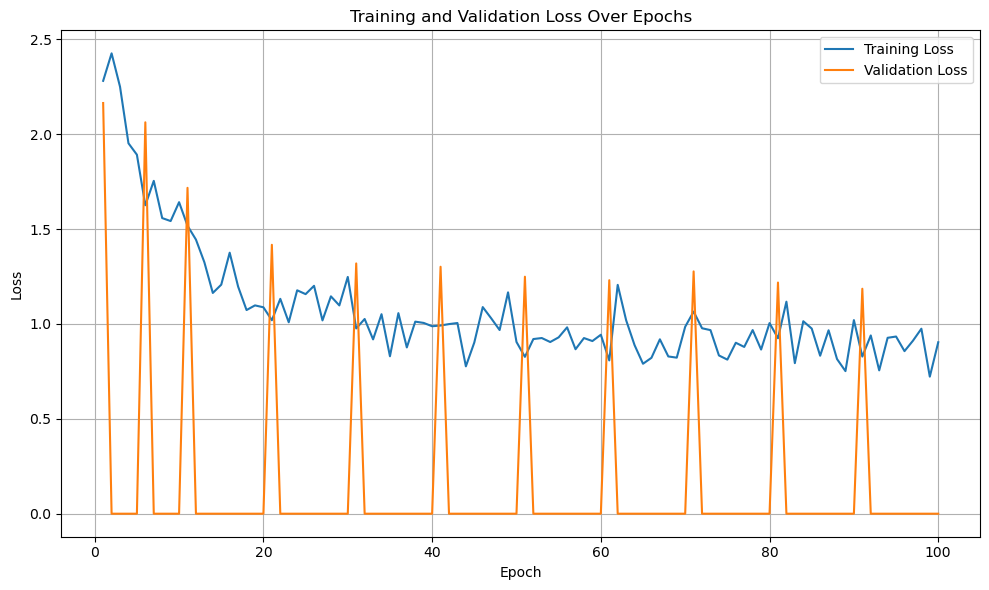

In [26]:
import matplotlib.pyplot as plt

def plot_training_losses(train_losses, test_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, test_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_training_losses(train_losses, test_losses)

In [27]:
#evaluate with test data
from sklearn.metrics import accuracy_score
# get files (during training, test_data is transformed so we will load it again)
output = io.load_train_test_data(test_dir, image_filter='_image_stack', mask_filter='__mask')
test_data, test_labels = output[:2]

model_path = "/home/kryten/Desktop/Imatges_AIna/database_seg_sergi/train/models/CP_sergi_cyto2_200"
model = models.CellposeModel(gpu=True, pretrained_model=model_path)

# run model on test images
masks = model.eval(test_data, 
                   channels=[chan, chan2]
                   )[0]

# check performance using ground truth labels
ap = metrics.average_precision(test_labels, masks)[0]
#accuracy = accuracy_score(test_labels, masks)
#print("Accuracy:", accuracy)
print('')
print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')

2025-04-10 16:49:27,002 [INFO] not all flows are present, running flow generation for all images
2025-04-10 16:49:27,069 [INFO] 21 / 21 images in /home/kryten/Desktop/Imatges_AIna/database_seg_sergi/test folder have labels
2025-04-10 16:49:27,108 [INFO] ** TORCH CUDA version installed and working. **
2025-04-10 16:49:27,108 [INFO] >>>> using GPU (CUDA)
2025-04-10 16:49:27,160 [INFO] >>>> loading model /home/kryten/Desktop/Imatges_AIna/database_seg_sergi/train/models/CP_sergi_cyto2_200
2025-04-10 16:49:27,189 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2025-04-10 16:49:27,189 [INFO] >>>> model diam_labels =  440.167 (mean diameter of training ROIs)
2025-04-10 16:50:43,846 [INFO] 100%|##########| 21/21 [01:16<00:00,  3.65s/it]

>>> average precision at iou threshold 0.5 = 0.690


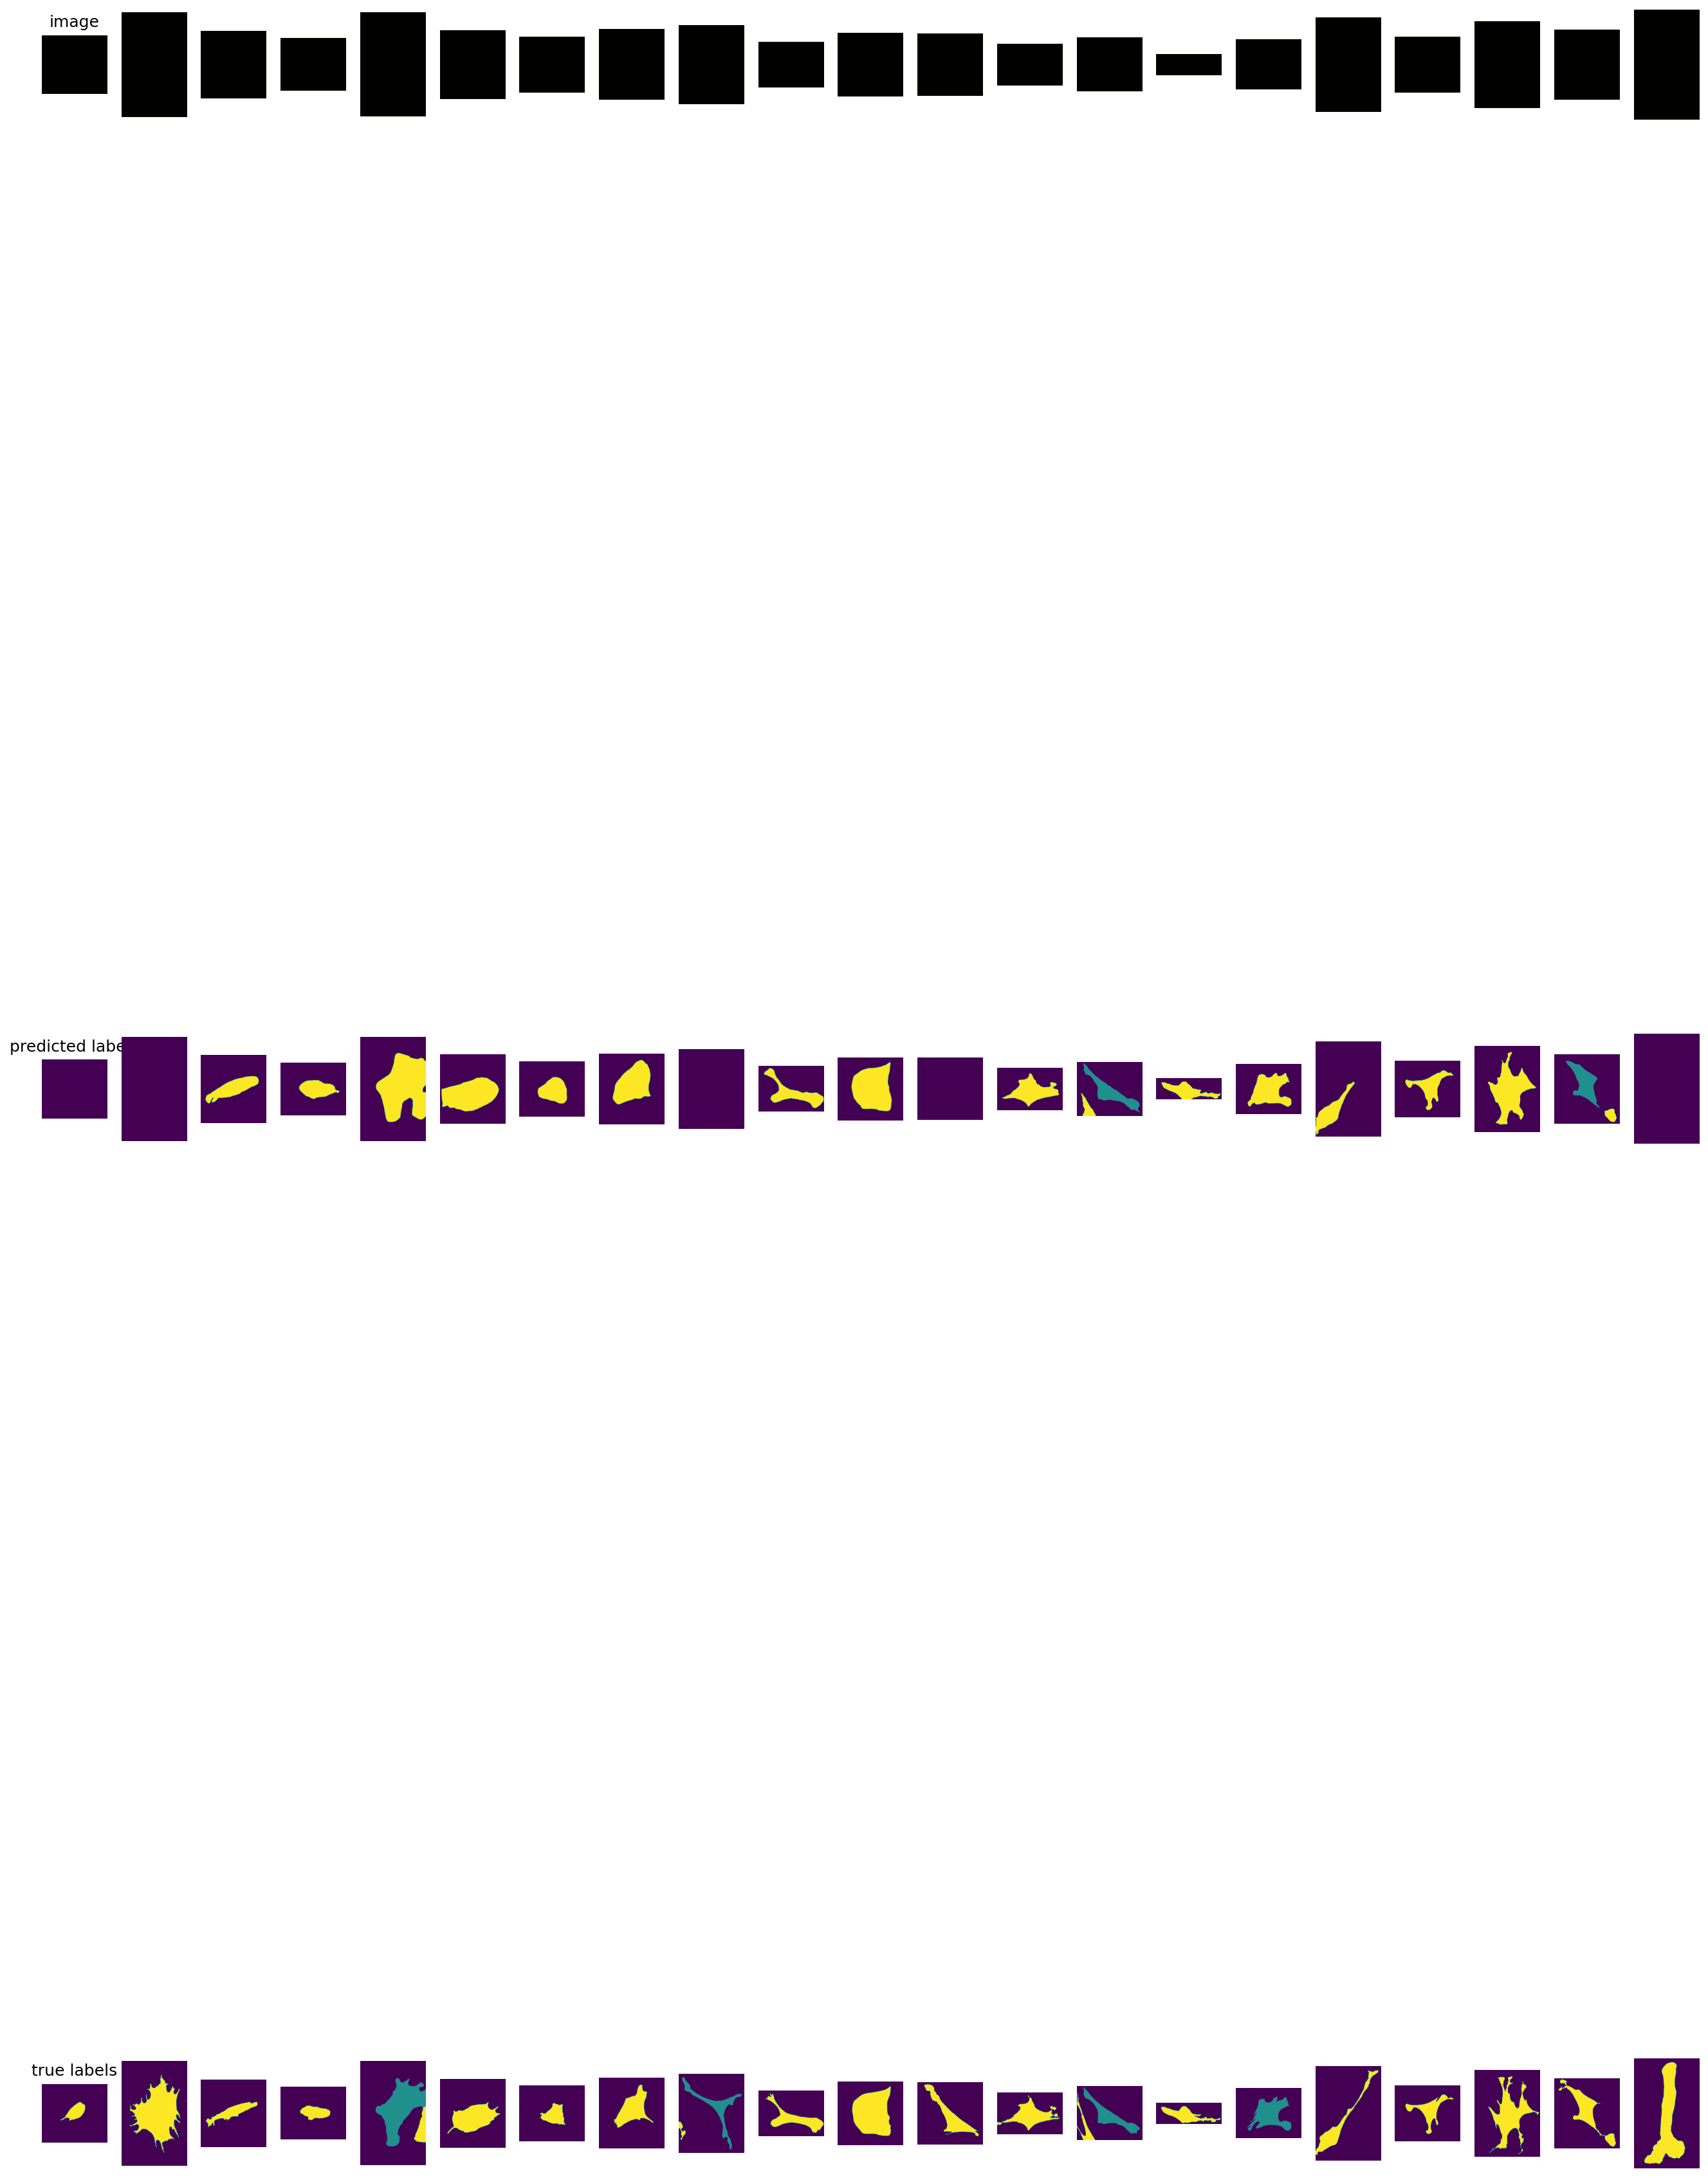

In [28]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(48,32), dpi=150)
for k,im in enumerate(test_data):
    img = im.copy()
    plt.subplot(3,len(train_dir), k+1)
    img = np.vstack((img, np.zeros_like(img)[:1]))
    img = img.transpose(1,2,0)
    img = np.clip(img, 0, 1) 
    plt.imshow(img)
    plt.axis('off')
    if k==0:
        plt.title('image')

    plt.subplot(3,len(train_dir), len(train_dir) + k+1)
    plt.imshow(masks[k])
    plt.axis('off')
    if k==0:
        plt.title('predicted labels')

    plt.subplot(3,len(train_dir), 2*len(train_dir) + k+1)
    plt.imshow(test_labels[k])
    plt.axis('off')
    if k==0:
        plt.title('true labels')
plt.tight_layout()

In [29]:
def dice_coef(y_true, y_pred):
    intersection = np.logical_and(y_true > 0, y_pred > 0).sum()
    union = y_true[y_true > 0].size + y_pred[y_pred > 0].size
    return 2.0 * intersection / union if union > 0 else 0.0

In [30]:
from cellpose import models, metrics
import tifffile
import os
import numpy as np
from glob import glob



def evaluate_and_save_masks(
    model,
    folder,
    channels,
    output_folder,
    flow_threshold=0.2,
    cellprob_threshold=-1.0,
    max_images=None
):
    os.makedirs(output_folder, exist_ok=True)
    image_files = sorted(glob(os.path.join(folder, "*_image_stack.tif")))
    if max_images:
        image_files = image_files[:max_images]

    ious, dices, aps = [], [], []

    for image_path in image_files:
        base = os.path.basename(image_path).replace('_image_stack.tif', '')
        mask_path = os.path.join(folder, f"{base}__mask.tif")
        if not os.path.exists(mask_path):
            print(f" Mask not found for {base}")
            continue

        image = tifffile.imread(image_path)
        true_mask = tifffile.imread(mask_path)

        # Skip empty masks
        if np.max(true_mask) == 0:
            print(f" Empty ground truth mask for {base}, skipping...")
            continue

        # Run model
        pred_mask, flows, styles = model.eval(
            image,
            channels=channels,
            flow_threshold=flow_threshold,
            cellprob_threshold=cellprob_threshold,
            progress=False
        )

        # Skip empty predictions
        '''if pred_mask is None:
            print(f" No predicted masks for {base}")
            continue'''

        # Save predicted mask
        save_path = os.path.join(output_folder, f"{base}__predicted_mask.tif")
        tifffile.imwrite(save_path, pred_mask.astype(np.uint16))

        # Calculate metrics
        iou_score = metrics.average_precision(true_mask, pred_mask)
        dice_score = dice_coef(true_mask, pred_mask)

        if iou_score[0] is not None:
            ious.append(iou_score[0])
            aps.append(iou_score[1])
            dices.append(dice_score)

    # Report
    if ious:
        print("\nEvaluation Results:")
        print(f"Mean IoU:  {np.mean(ious):.4f}")
        print(f"Mean Dice: {np.mean(dices):.4f}")
        print(f"Mean AP:   {np.mean(aps):.4f}")
    else:
        print(" No valid predictions to compute metrics.")

    return ious, dices, aps


In [31]:
# Cargar modelo
model_path = "/home/kryten/Desktop/Imatges_AIna/database_seg_sergi/train/models/CP_sergi_cyto2_200"
model = models.CellposeModel(gpu=True, pretrained_model=model_path)

# Evaluar y guardar máscaras
evaluate_and_save_masks(
    model=model,
    folder=test_dir,                       # carpeta con imágenes y máscaras reales
    channels=channels,                             # 1 = rojo (actina), 2 = verde (núcleo)
    output_folder="/home/kryten/Desktop/Imatges_AIna/database_seg_sergi/predicted",
    flow_threshold=0.4,
    cellprob_threshold=-1.0,                     # valor permisivo para no eliminar células débiles
    max_images=None                              # o usa 10 si quieres probar solo con algunas
)

''' parametros con mayor accuracy y mayor cantidad de máscaras predichas: flow_threshold=0.4 y cellprob_threshold=-1
IoU = Área de superposición / Área de unión --> cuánto se solapan las áreas predichas por el modelo con las áreas reales (ground truth)
Dice = (2 * Intersección) / (Predicción + Real)
AP = Media de la precisión promedio (AP) en diferentes thresholds de IoU

'''

2025-04-10 16:51:35,247 [INFO] ** TORCH CUDA version installed and working. **
2025-04-10 16:51:35,248 [INFO] >>>> using GPU (CUDA)
2025-04-10 16:51:35,276 [INFO] >>>> loading model /home/kryten/Desktop/Imatges_AIna/database_seg_sergi/train/models/CP_sergi_cyto2_200
2025-04-10 16:51:35,305 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2025-04-10 16:51:35,306 [INFO] >>>> model diam_labels =  440.167 (mean diameter of training ROIs)

Evaluation Results:
Mean IoU:  0.2222
Mean Dice: 0.5223
Mean AP:   0.2540


' parametros con mayor accuracy y mayor cantidad de máscaras predichas: flow_threshold=0.4 y cellprob_threshold=-1\nIoU = Área de superposición / Área de unión --> cuánto se solapan las áreas predichas por el modelo con las áreas reales (ground truth)\nDice = (2 * Intersección) / (Predicción + Real)\nAP = Media de la precisión promedio (AP) en diferentes thresholds de IoU\n\n'

In [32]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from tifffile import imread
def visualize_predictions_with_diagnosis(pred_folder, test_folder, num_images=10):
    pred_files = sorted([f for f in os.listdir(pred_folder) if f.endswith("__predicted_mask.tif")])
    if not pred_files:
        print(" No predicted masks found.")
        return

    random.seed(42)
    samples = random.sample(pred_files, min(num_images, len(pred_files)))

    for pred_file in samples:
        base = pred_file.replace("__predicted_mask.tif", "")
        image_path = os.path.join(test_folder, f"{base}_image_stack.tif")
        true_mask_path = os.path.join(test_folder, f"{base}__mask.tif")
        pred_mask_path = os.path.join(pred_folder, pred_file)

        if not (os.path.exists(image_path) and os.path.exists(true_mask_path)):
            print(f" Faltan archivos para {base}, se omite.")
            continue

        image = imread(image_path)
        true_mask = imread(true_mask_path)
        pred_mask = imread(pred_mask_path)

        pred_empty = np.max(pred_mask) == 0
        true_empty = np.max(true_mask) == 0

        status = " OK" if not pred_empty else " Sin predicción"
        print(f" {base}: {status}")

        fig, axs = plt.subplots(1, 3, figsize=(14, 5))
        axs[0].imshow(image[0], cmap='gray')
        axs[0].set_title("Canal 1 (Actina)")
        axs[1].imshow(true_mask, cmap='nipy_spectral')
        axs[1].set_title("Máscara Real")
        axs[2].imshow(pred_mask, cmap='nipy_spectral')
        axs[2].set_title("Máscara Predicha")
        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

 cell24_aug0:  OK


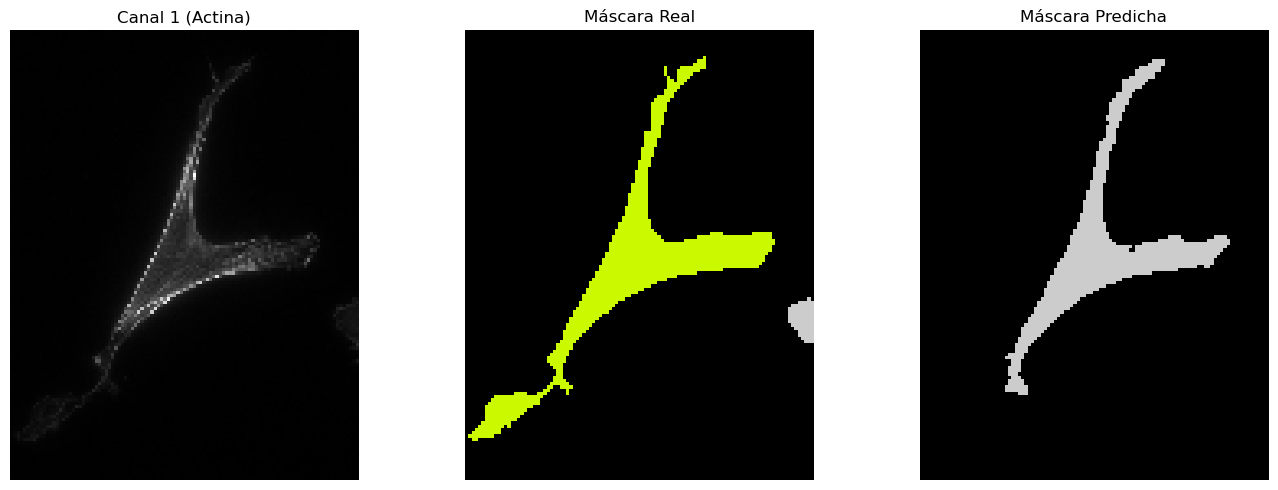

 2_cell20:  OK


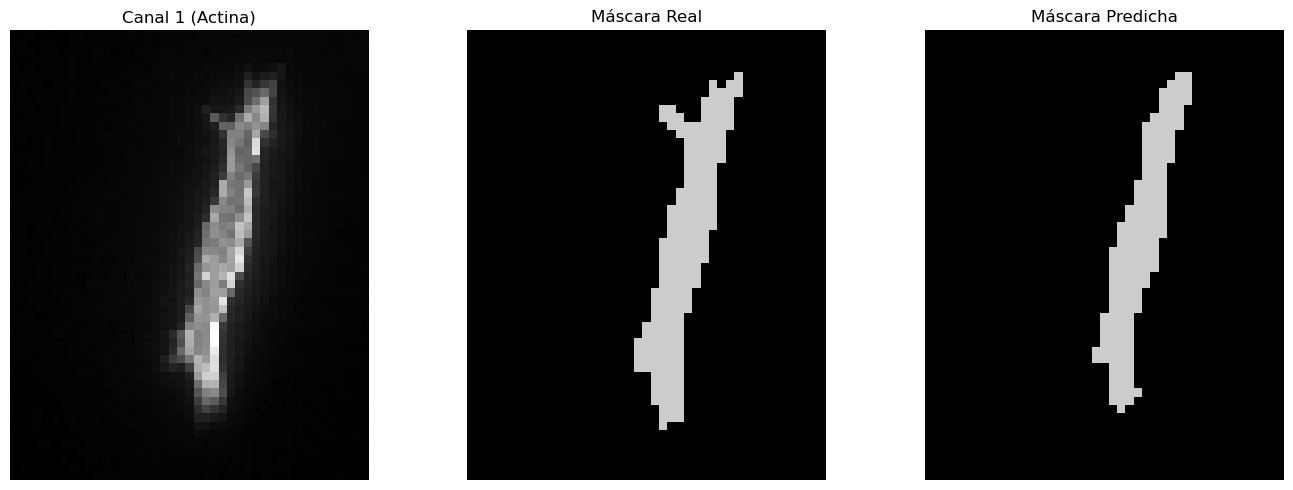

 2_cell15_aug0:  OK


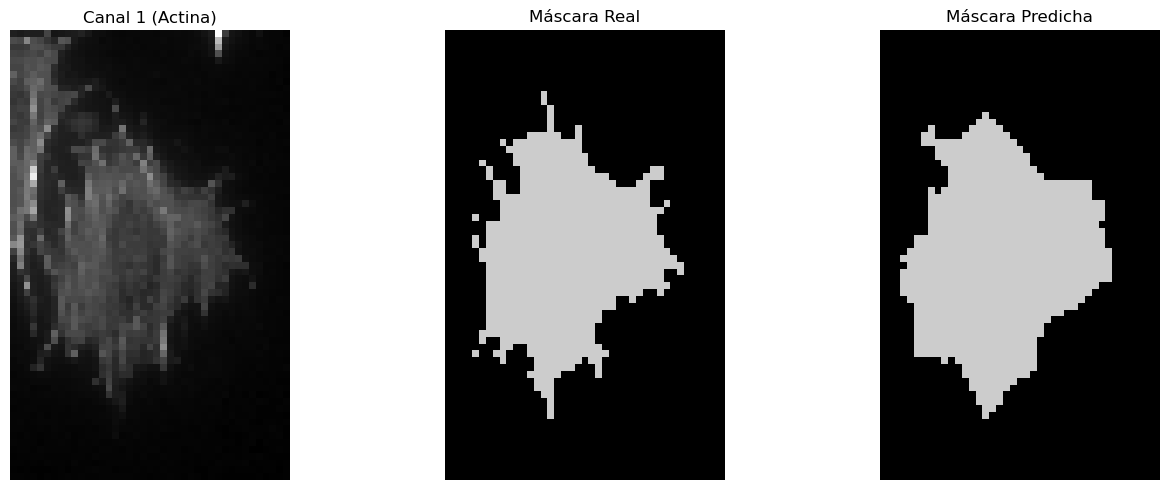

 cell34:  OK


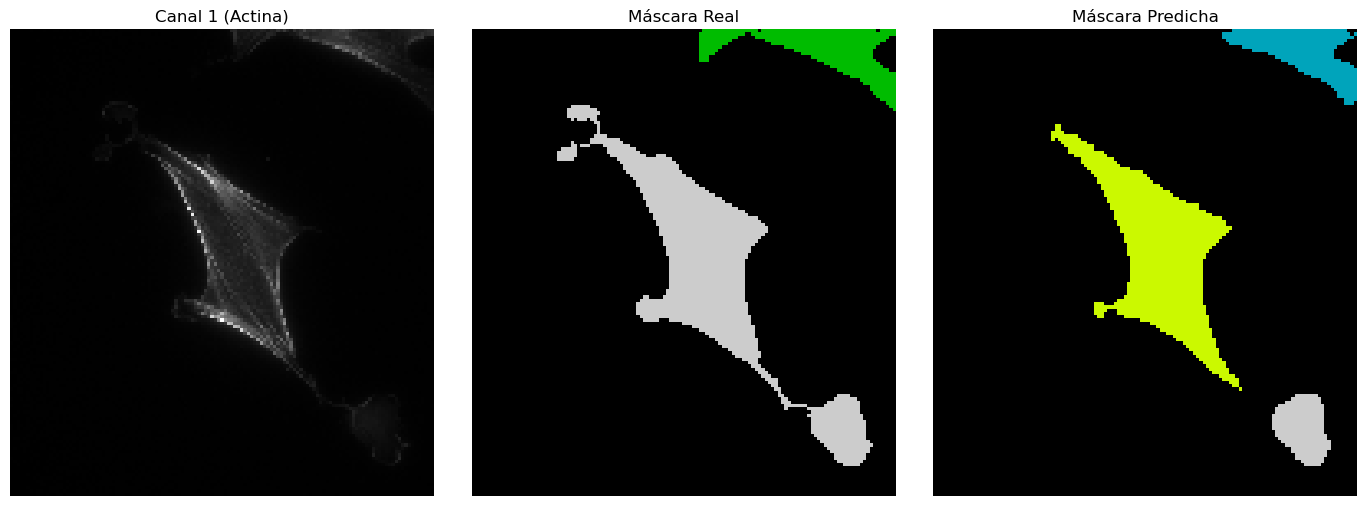

 2_cell33_aug1:  OK


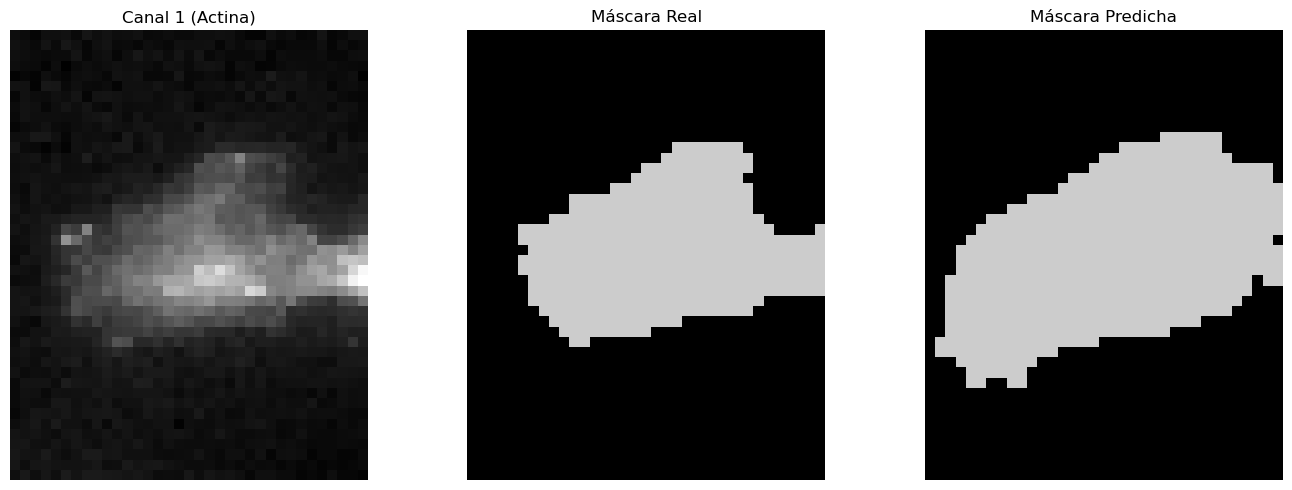

 2_cell32:  OK


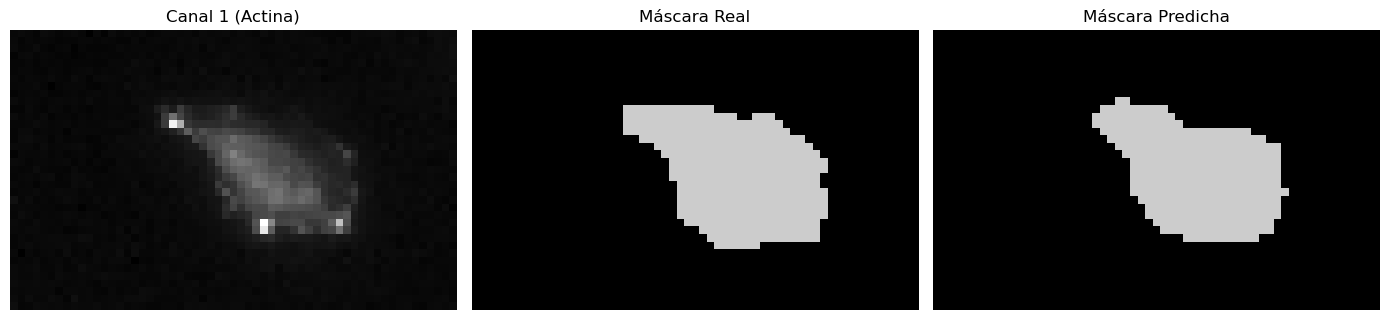

 2_cell31_aug1:  OK


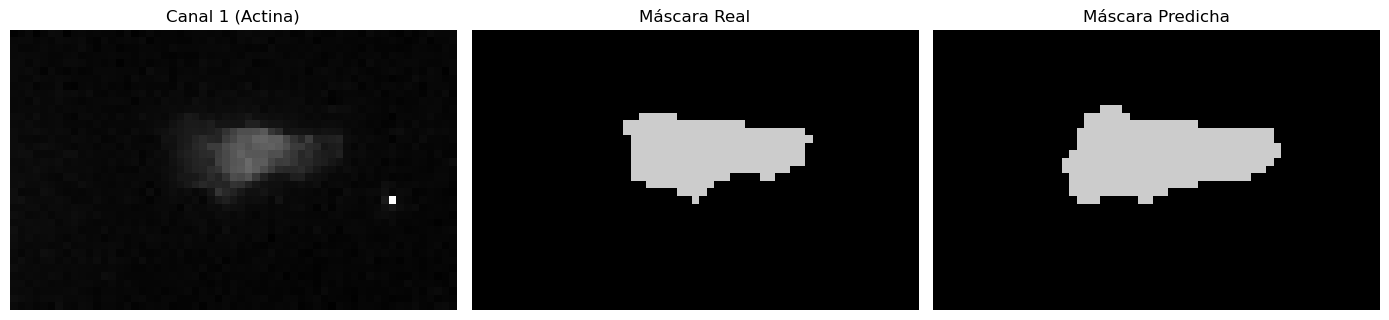

 2_cell21:  OK


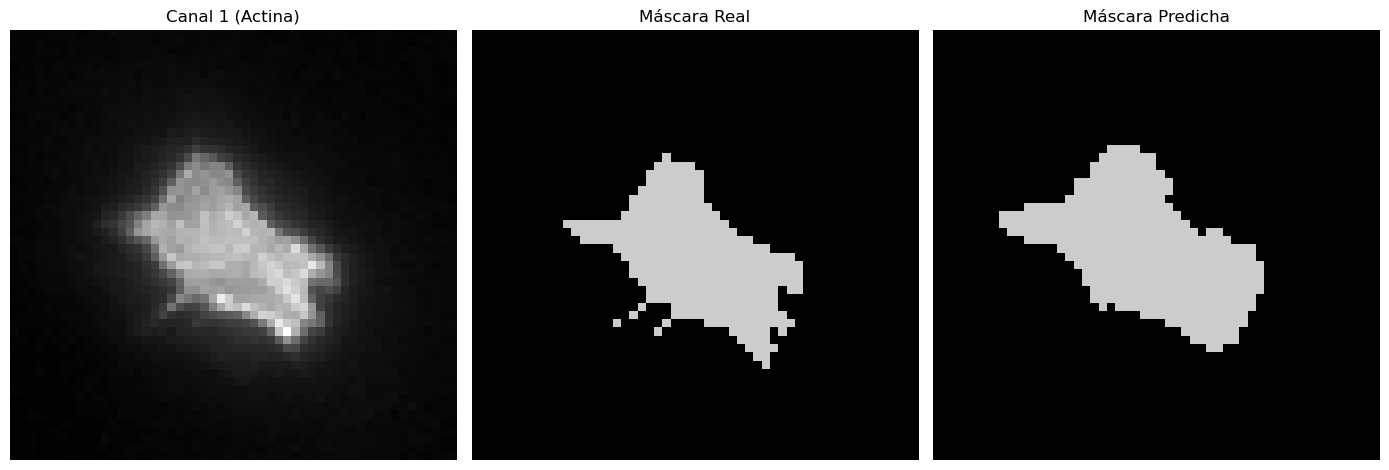

 cell4:  OK


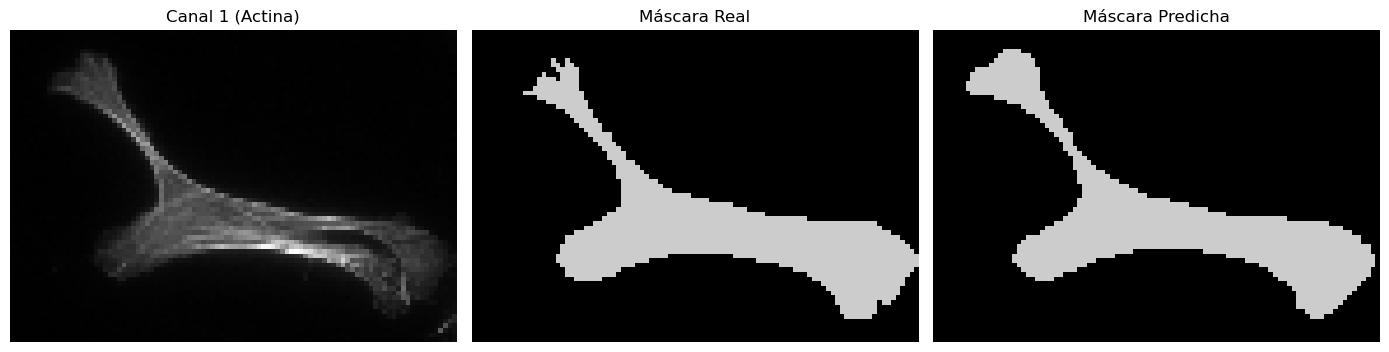

 2_cell1_aug1:  OK


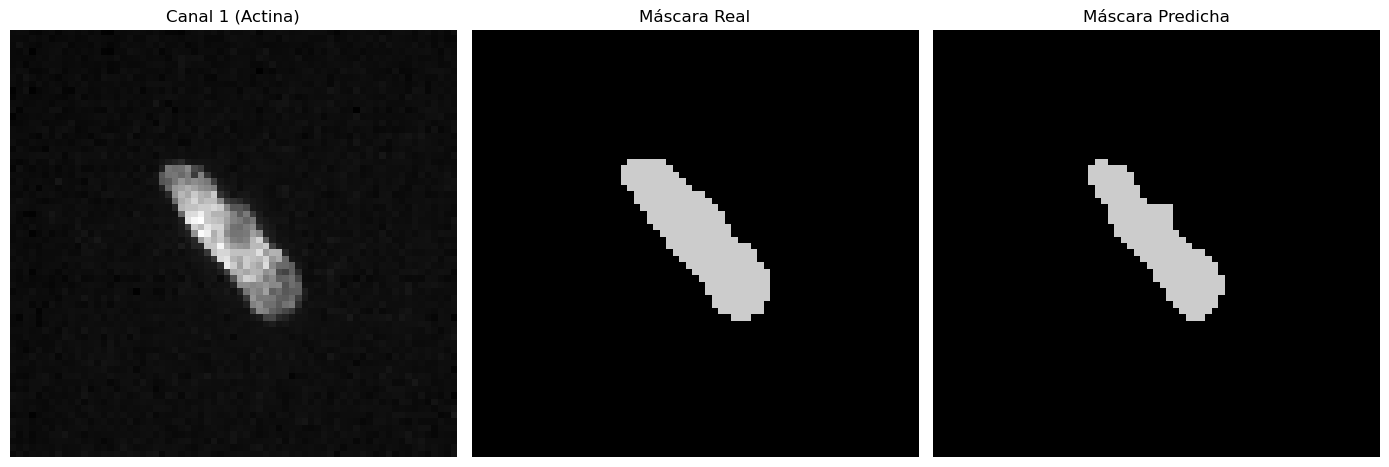

 cell26:  OK


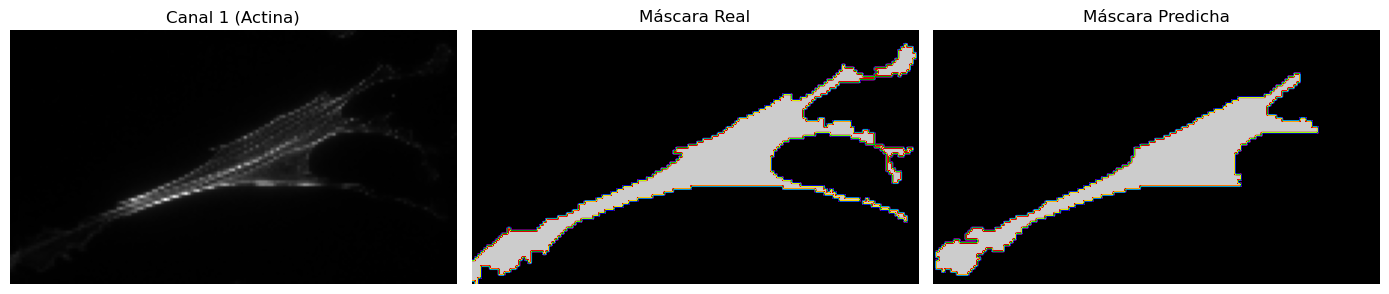

 cell45_aug0:  OK


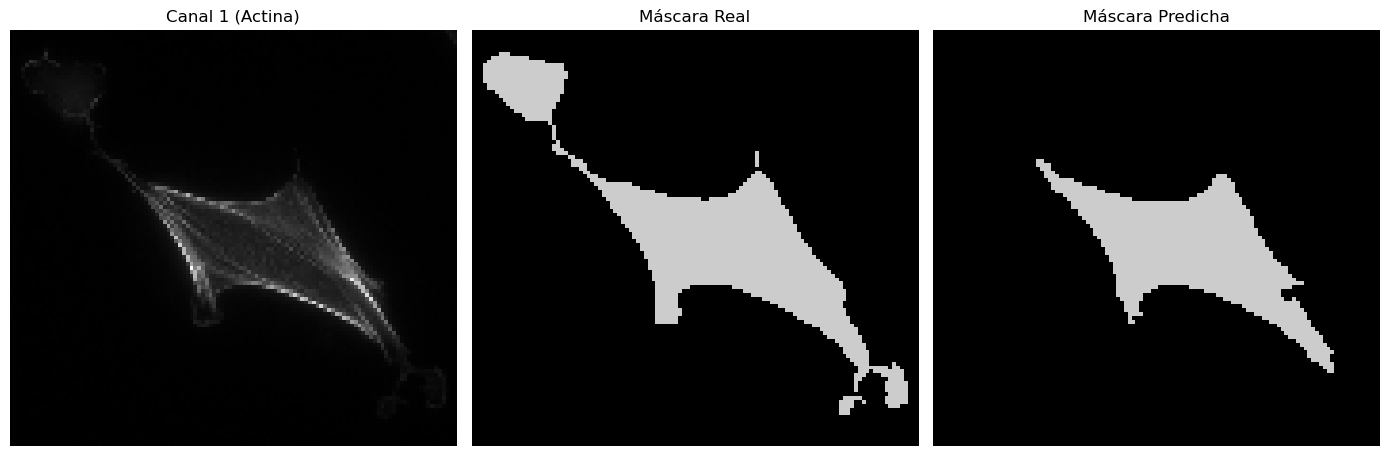

 cell11:  OK


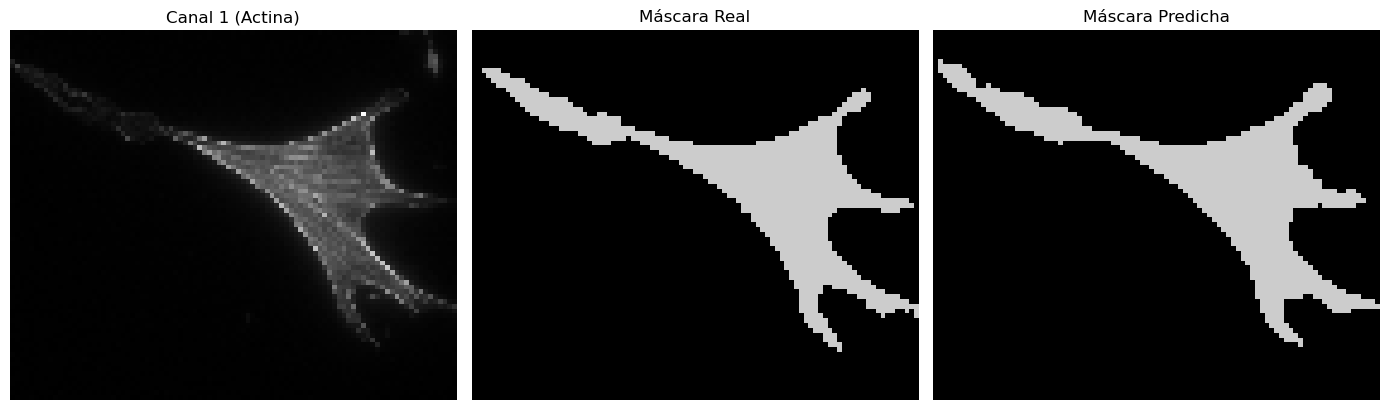

 2_cell1_aug0:  OK


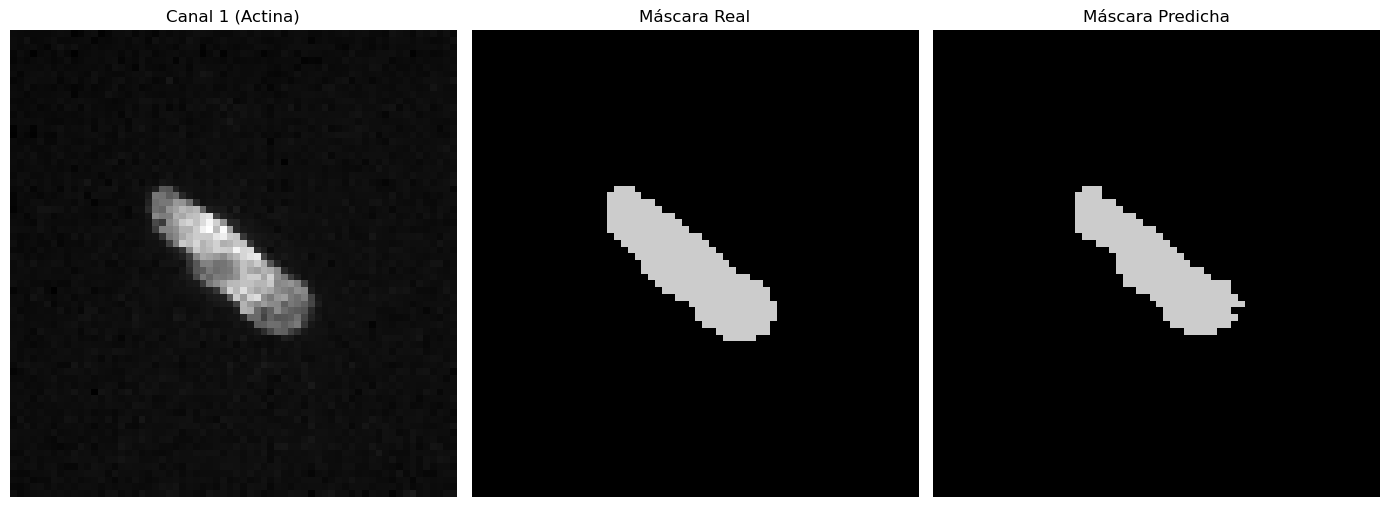

 cell17_aug1:  OK


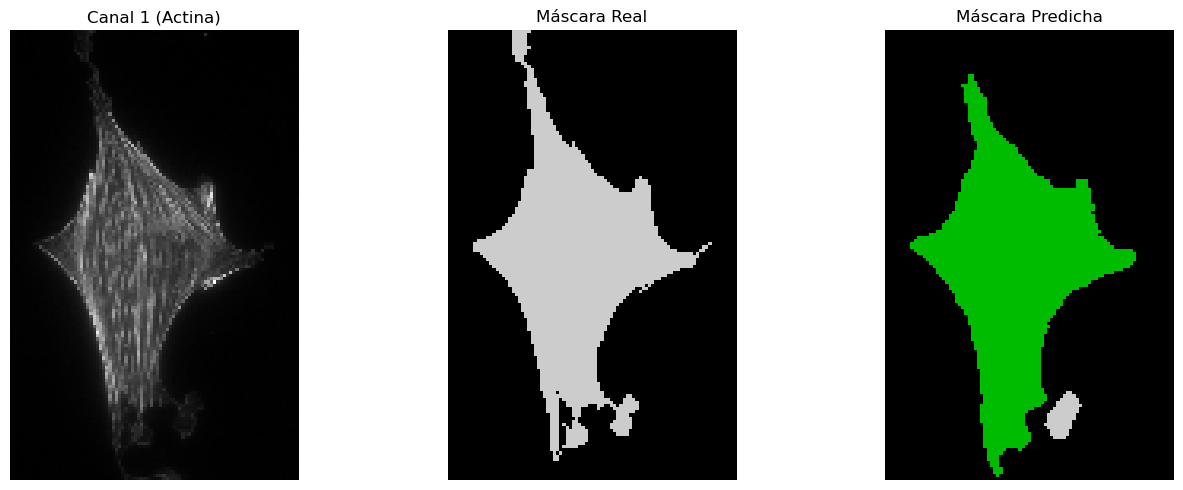

 2_cell46:  OK


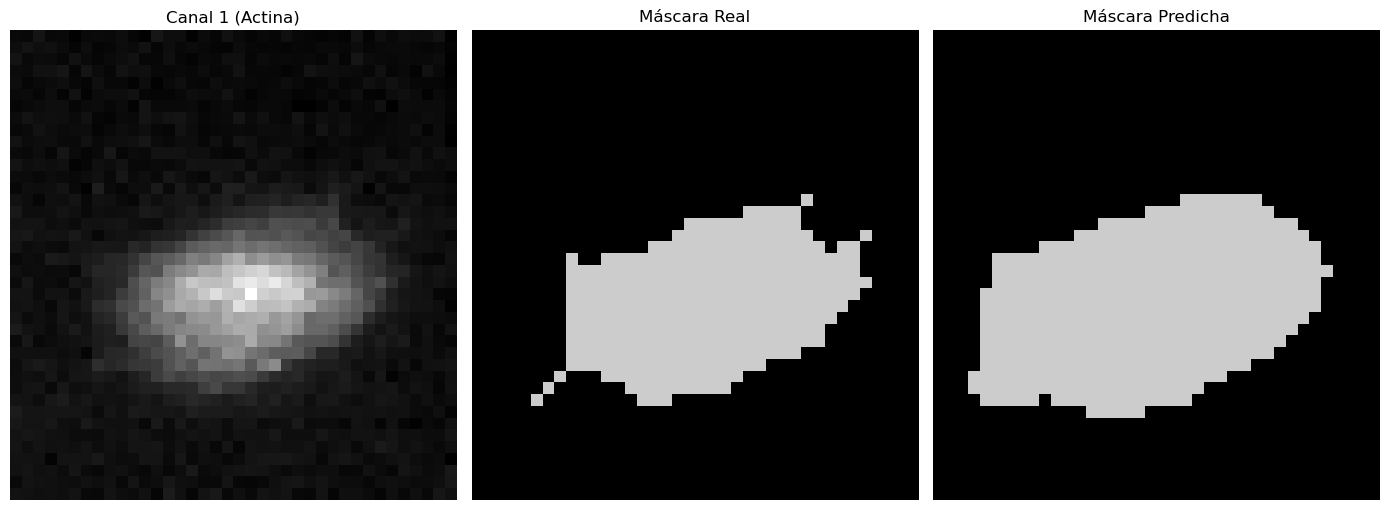

 2_cell15_aug1:  Sin predicción


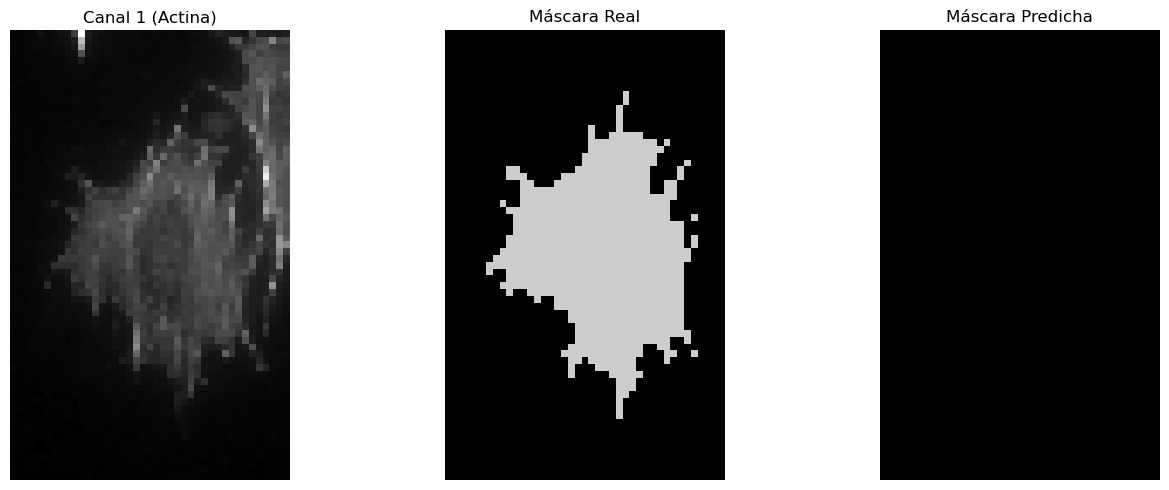

 cell50_aug1:  Sin predicción


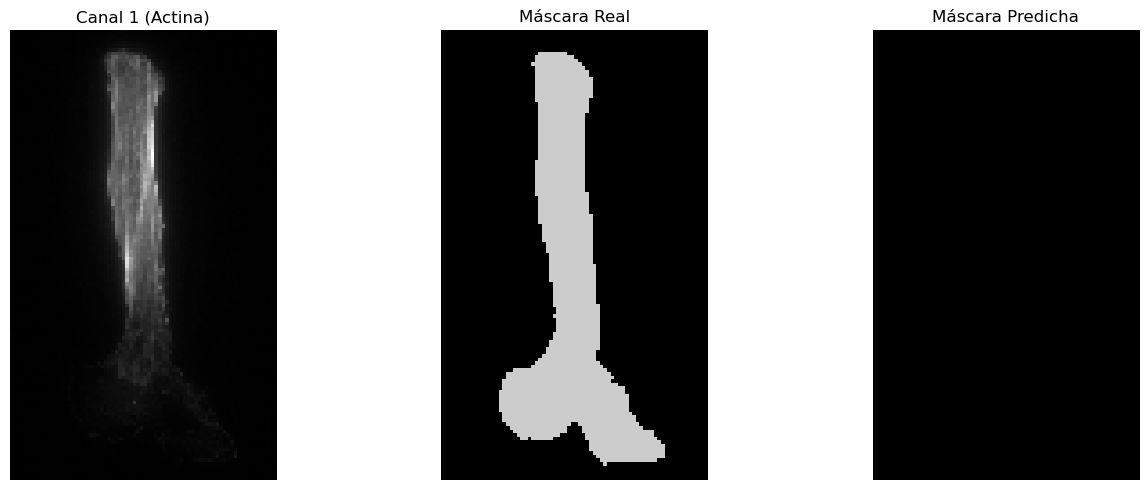

 cell38_aug1:  OK


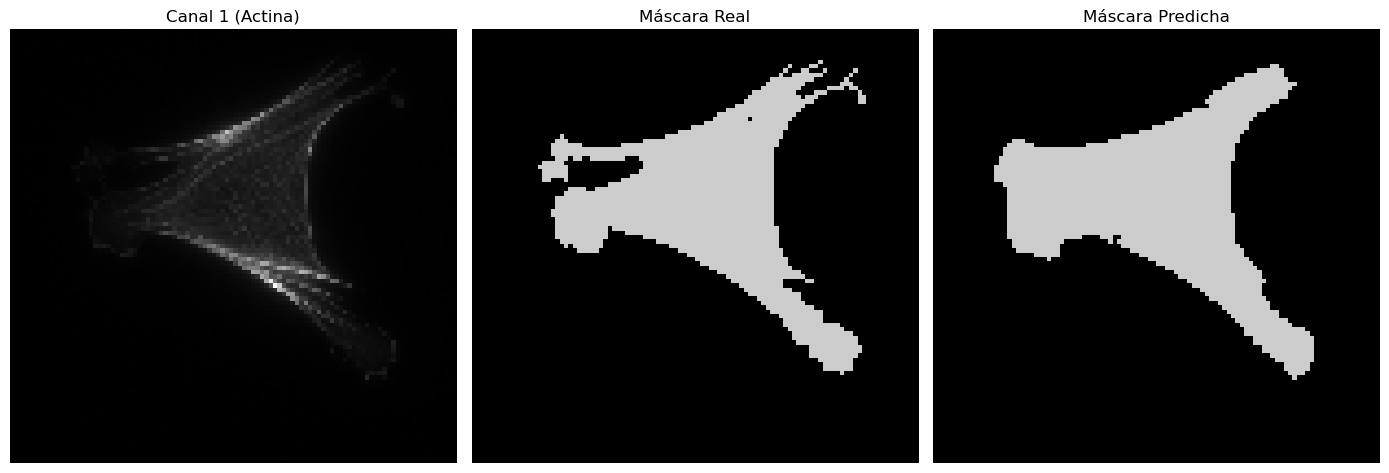

 2_cell26:  OK


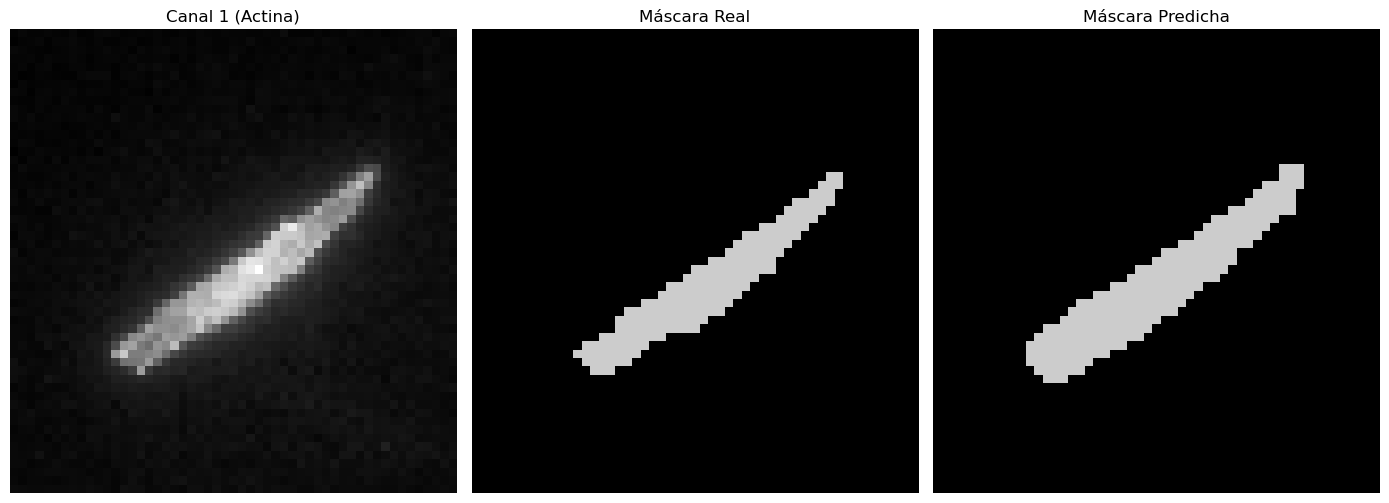

In [19]:

visualize_predictions_with_diagnosis(
    pred_folder="/home/kryten/Desktop/Imatges_AIna/database_seg_sergi_rs_aug/predicted",
    test_folder=test_dir,
    num_images=20
)